# **Intel Image Classification**

Import Python Library

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2

**Data Understanding**

In [20]:
train_dir = 'data/seg_train/seg_train'
test_dir = 'data/seg_test/seg_test'
pred_dir = 'data/seg_pred/seg_pred'

In [21]:
classes = os.listdir(train_dir)
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


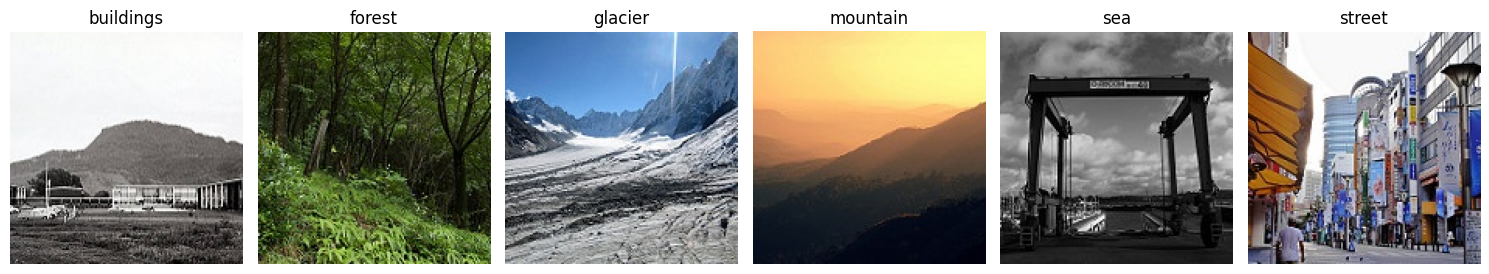

In [22]:
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
for idx, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if image_files:
        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(class_name)
        axes[idx].axis('off')
    else:
        axes[idx].set_title(class_name + "\n(No images found)")
        axes[idx].axis('off')
plt.tight_layout()
plt.show()

**EDA**

Text(0, 0.5, 'Number of images')

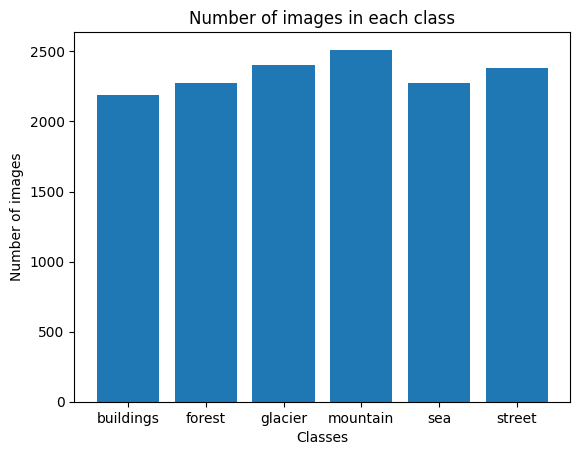

In [23]:
number_class = {
    'buildings': len(os.listdir(os.path.join(train_dir, 'buildings'))),
    'forest': len(os.listdir(os.path.join(train_dir, 'forest'))),
    'glacier': len(os.listdir(os.path.join(train_dir, 'glacier'))),
    'mountain': len(os.listdir(os.path.join(train_dir, 'mountain'))),
    'sea': len(os.listdir(os.path.join(train_dir, 'sea'))),
    'street': len(os.listdir(os.path.join(train_dir, 'street')))
}

plt.bar(number_class.keys(), number_class.values(), width = .8)
plt.title('Number of images in each class')
plt.xlabel('Classes')
plt.ylabel('Number of images')

In [24]:
height, width, channels = img.shape
print(f"Image dimensions: {height}x{width}, Channels: {channels}")

Image dimensions: 150x150, Channels: 3


**Modelling**

In [27]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(height, width),
    batch_size=32,
    label_mode='categorical')
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(height, width),
    batch_size=32,
    label_mode='categorical')

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [28]:
image_class = train_set.class_names
print(image_class)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [29]:
model = tf.keras.Sequential()

In [30]:
import_model = tf.keras.applications.ResNet50(
    input_shape=(height, width, channels),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classes=len(image_class)
)
for layer in import_model.layers:
    layer.trainable = False

19259392/94765736 ━━━━━━━━━━━━━━━━━━━━ 46:03 37us/step

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- retrieval incomplete: got only 19253716 out of 94765736 bytes

In [ ]:
model.add(import_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(len(image_class), activation='softmax'))

In [ ]:
model.summary()